In [1]:
%matplotlib inline

# Transfer Learning
In this assignment, we will use the weights of a network pre-trained in a particular problem as starting point to train our CNN to a different problem. As training a network from scratch is time-consuming and demands a lot of data, this is a frequent strategy, specially if both datasets (the one used for pre-training and the target) shares similar structures/elements/concepts. 

This is specially true when working with images. Most filters learned in initial convolutional layers will detect low-level elements, such as borders, corners and color blobs, which are common to most problems in the image domain. 

In this notebook, we will load the SqueezeNet architecture trained in the ImageNet dataset and fine-tune it to CIFAR-10.

## Imports

In [2]:
!pip install keras==2.2.4

In [3]:
import os
import numpy as np
import sklearn
import keras
print('The scikit-learn version is {}.'.format(sklearn.__version__))
from random import sample, seed
seed(42)
np.random.seed(42)
from time import time
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = (15,15) # Make the figures a bit bigger

# Keras imports
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras import regularizers
from keras import optimizers
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.image import load_img, img_to_array
from keras.datasets import cifar10
from keras.callbacks import TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
if (sklearn.__version__ == '0.20.0'):
    from sklearn.model_selection import StratifiedShuffleSplit
else:
    from sklearn.cross_validation import StratifiedShuffleSplit


#======================================
# Global definitions
#======================================
n_epochs         = 100
learning_rate    = 1e-4
n_classes        = 10
train_batch_size = 384
val_batch_size   = 128
    
#Utility to plot
def plotImages(imgList):
    for i in range(len(imgList)):
        plotImage(imgList[i])
        
        
def plotImage(img):
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)

    ax.imshow(np.uint8(img), interpolation='nearest')
    plt.show()

Using TensorFlow backend.


The scikit-learn version is 0.20.0.


## SqueezeNet definition
These methods define our architecture and load the weights obtained using ImageNet data.

In [4]:
# Fire Module Definition
sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x

#SqueezeNet model definition
def SqueezeNet(input_shape):
    img_input = Input(shape=input_shape) #placeholder
    
    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    x = Dropout(0.5, name='drop9')(x)

    x = Convolution2D(1000, (1, 1), padding='valid', name='conv10')(x)
    x = Activation('relu', name='relu_conv10')(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation('softmax', name='loss')(x)

    model = Model(img_input, x, name='squeezenet')

    # Download and load ImageNet weights
    model.load_weights('./squeezenet_weights_tf_dim_ordering_tf_kernels.h5')
    
    return model    

## CIFAR-10

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. The class are **airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck**.

In [5]:
#Load data
(trainVal_data, trainVal_label), (X_test, y_test) = cifar10.load_data()
print("Train/Val data. X: ", trainVal_data.shape, ", Y: ", trainVal_label.shape)
print("Test data. X: ", X_test.shape, ", Y: ", y_test.shape)

# Normalizing the data
trainVal_data = (trainVal_data / 127.5) - 1.
X_test = (X_test  / 127.5) - 1.

#=====================================
# Prepare the data
#=====================================

#--- Dividing the data into training and validation
folds = 5
if (sklearn.__version__ == '0.20.0'):
    sss = StratifiedShuffleSplit(folds, test_size=0.2, random_state=42)
    sss = sss.split(trainVal_data,trainVal_label)
else:
    sss = StratifiedShuffleSplit(trainVal_label, folds, test_size=0.2, random_state=42)
X_train = []
y_train = []
X_val = []
y_val = []
for train_index, val_index in sss:
    X_train.append(trainVal_data[train_index])
    X_val.append(trainVal_data[val_index])
    y_train.append(trainVal_label[train_index])
    y_val.append(trainVal_label[val_index])

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
    
print("--- Splitting data into train and val")
print("Train data. X:",X_train.shape,"Y:",y_train.shape)
print("Val data. X:",X_val.shape,"Y:",y_val.shape)

Train/Val data. X:  (50000, 32, 32, 3) , Y:  (50000, 1)
Test data. X:  (10000, 32, 32, 3) , Y:  (10000, 1)
--- Splitting data into train and val
Train data. X: (5, 40000, 32, 32, 3) Y: (5, 40000, 1)
Val data. X: (5, 10000, 32, 32, 3) Y: (5, 10000, 1)


[4000 4000 4000 4000 4000 4000 4000 4000 4000 4000]


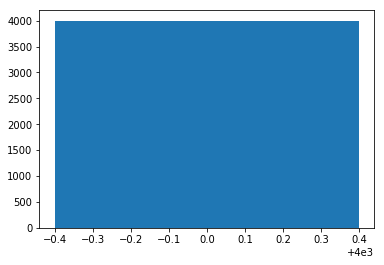

[4000 4000 4000 4000 4000 4000 4000 4000 4000 4000]


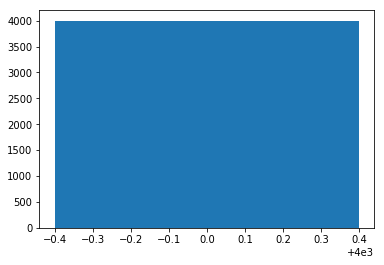

[4000 4000 4000 4000 4000 4000 4000 4000 4000 4000]


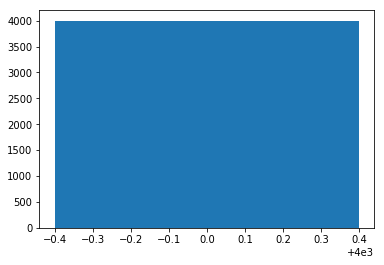

[4000 4000 4000 4000 4000 4000 4000 4000 4000 4000]


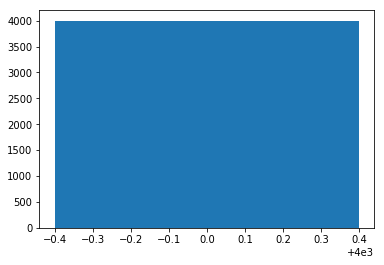

[4000 4000 4000 4000 4000 4000 4000 4000 4000 4000]


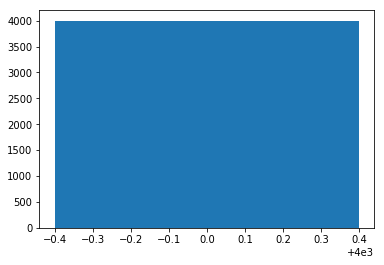

<Figure size 432x288 with 0 Axes>

In [6]:
# Cheking if the splits are balanced
for i in range(folds):
    hist = np.histogram(np.squeeze(y_train[i]))[0]
    print(hist)    
    plt.bar(hist,np.amax(hist),alpha=0.5)
    plt.show()
    plt.clf()

-----------------
## SqueezeNet with frozen layers
Our initial attempt will be to remove SqueezeNet's top layers --- responsible for the classification into ImageNet classes --- and train a new set of layers to our CIFAR-10 classes. We will also freeze the layers before `drop9`. Our architecture will be like this:

<img src="frozenSqueezeNet.png" width=70% height=70%>

In [7]:
def get_squeezenet_ft():
    #=====================================
    # Freezing layers
    #=====================================

    squeezeNetModel = SqueezeNet((32,32,3))

    #freeze layers
    for layer in squeezeNetModel.layers:
        layer.trainable = False

    #=====================================
    # Add new classification layers
    #=====================================

    #--- Removing layers until drop 9
    squeezeNetModel.layers.pop() #Convolution2D
    squeezeNetModel.layers.pop() #Activation ReLU
    squeezeNetModel.layers.pop() #Global Avg Pool
    squeezeNetModel.layers.pop() #Activation Softmax

    #--- Adding classification layer for 10 classes
    out = Convolution2D(n_classes, (1, 1), padding='valid', name='conv10')(squeezeNetModel.layers[-1].output)
    out = Activation('relu', name='relu_conv10')(out)

    out = GlobalAveragePooling2D()(out)
    out = Activation('softmax', name='loss')(out)

    #=====================================
    # New Model
    #=====================================
    model = Model(squeezeNetModel.inputs, out, name='squeezenet_new')
    #=====================================
    # Compile model
    #=====================================


    opt = optimizer=optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)#SGD(lr=learning_rate)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

model  = get_squeezenet_ft()
model.summary()

#--- Check the trainable status of the individual layers
for layer in model.layers:
    print(layer.name, layer.trainable)


Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 15, 15, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 15, 15, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 7, 7, 64)     0           relu_conv1[0][0]                 
_____________________________________

Now, we compile our model and train it:

In [8]:
#=====================================
# Training model and Evaluation
#=====================================

y_train_categorical = to_categorical(y_train, num_classes=n_classes)
y_val_categorical = to_categorical(y_val, num_classes=n_classes)

scores = []
for i in range(folds):
    #--- Loading model
    model  = get_squeezenet_ft()

    
    #--- Evaluating the model for split i
    print("================================================")
    print("Split: "+str(i))
    print("Number of Epochs: "+str(n_epochs))
    print("Train shape:",X_train[i].shape)
    print("Train batch size: "+str(train_batch_size))
    print("Val batch size: "+str(val_batch_size))
    print("================================================")
    
    #=====================================
    # Tensorboard callback
    #=====================================
    print("--- Preparing tensorboard")
    log_dir = "logs/{}_fold[{}]_{}".format(time(), i, 'pre-trained')
    print("Log Dir: ", log_dir)
    tbCallBack = TensorBoard(log_dir=log_dir, write_graph=True)    
    
    # Training without data augmentation
    model.fit(X_train[i],y_train_categorical[i], batch_size=train_batch_size, 
              epochs=n_epochs, 
              validation_data=(X_val[i],y_val_categorical[i]),
              verbose=1,
              callbacks=[tbCallBack])
    
    #--- Evaluating the model for split i
    score = model.evaluate(x=X_val[i], y=y_val_categorical[i], batch_size=val_batch_size, verbose=1)
    scores.append(score)
    print('Validation loss:', score[0])
    print('Validation accuracy (NORMALIZED):', score[1])
    
#--- Showing scores
print(scores)

Split: 0
Number of Epochs: 100
Train shape: (40000, 32, 32, 3)
Train batch size: 384
Val batch size: 128
--- Preparing tensorboard
Log Dir:  logs/1542818922.0200126_fold[0]_pre-trained
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 2s 50us/step - loss: 2.3574 - acc: 0.1033 - val_loss: 2.3015 - val_acc: 0.1100
Epoch 2/100
40000/40000 [==============================] - 1s 29us/step - loss: 2.3157 - acc: 0.1139 - val_loss: 2.2908 - val_acc: 0.1386
Epoch 3/100
40000/40000 [==============================] - 1s 29us/step - loss: 2.2946 - acc: 0.1317 - val_loss: 2.2773 - val_acc: 0.1856
Epoch 4/100
40000/40000 [==============================] - 1s 29us/step - loss: 2.2816 - acc: 0.1451 - val_loss: 2.2580 - val_acc: 0.2170
Epoch 5/100
40000/40000 [==============================] - 1s 29us/step - loss: 2.2631 - acc: 0.1669 - val_loss: 2.2302 - val_acc: 0.2444
Epoch 6/100
40000/40000 [==============================] - 1s 29us/step - l

40000/40000 [==============================] - 1s 29us/step - loss: 1.8105 - acc: 0.3530 - val_loss: 1.7193 - val_acc: 0.4140
Epoch 58/100
40000/40000 [==============================] - 1s 29us/step - loss: 1.8053 - acc: 0.3575 - val_loss: 1.7178 - val_acc: 0.4137
Epoch 59/100
40000/40000 [==============================] - 1s 28us/step - loss: 1.8078 - acc: 0.3561 - val_loss: 1.7164 - val_acc: 0.4122
Epoch 60/100
40000/40000 [==============================] - 1s 28us/step - loss: 1.8104 - acc: 0.3530 - val_loss: 1.7151 - val_acc: 0.4146
Epoch 61/100
40000/40000 [==============================] - 1s 28us/step - loss: 1.8068 - acc: 0.3539 - val_loss: 1.7139 - val_acc: 0.4142
Epoch 62/100
40000/40000 [==============================] - 1s 28us/step - loss: 1.8078 - acc: 0.3556 - val_loss: 1.7126 - val_acc: 0.4144
Epoch 63/100
40000/40000 [==============================] - 1s 28us/step - loss: 1.8027 - acc: 0.3548 - val_loss: 1.7117 - val_acc: 0.4136
Epoch 64/100
40000/40000 [==============

Epoch 13/100
40000/40000 [==============================] - 1s 27us/step - loss: 2.0620 - acc: 0.2697 - val_loss: 1.9660 - val_acc: 0.3537
Epoch 14/100
40000/40000 [==============================] - 1s 27us/step - loss: 2.0341 - acc: 0.2739 - val_loss: 1.9401 - val_acc: 0.3564
Epoch 15/100
40000/40000 [==============================] - 1s 27us/step - loss: 2.0081 - acc: 0.2826 - val_loss: 1.9206 - val_acc: 0.3647
Epoch 16/100
40000/40000 [==============================] - 1s 27us/step - loss: 1.9894 - acc: 0.2922 - val_loss: 1.9049 - val_acc: 0.3694
Epoch 17/100
40000/40000 [==============================] - 1s 27us/step - loss: 1.9704 - acc: 0.2963 - val_loss: 1.8911 - val_acc: 0.3714
Epoch 18/100
40000/40000 [==============================] - 1s 27us/step - loss: 1.9575 - acc: 0.3032 - val_loss: 1.8790 - val_acc: 0.3784
Epoch 19/100
40000/40000 [==============================] - 1s 27us/step - loss: 1.9438 - acc: 0.3072 - val_loss: 1.8682 - val_acc: 0.3791
Epoch 20/100
40000/40000 [=

Epoch 72/100
40000/40000 [==============================] - 1s 27us/step - loss: 1.7955 - acc: 0.3608 - val_loss: 1.7065 - val_acc: 0.4124
Epoch 73/100
40000/40000 [==============================] - 1s 27us/step - loss: 1.7923 - acc: 0.3613 - val_loss: 1.7055 - val_acc: 0.4158
Epoch 74/100
40000/40000 [==============================] - 1s 27us/step - loss: 1.7914 - acc: 0.3603 - val_loss: 1.7043 - val_acc: 0.4149
Epoch 75/100
40000/40000 [==============================] - 1s 27us/step - loss: 1.7925 - acc: 0.3606 - val_loss: 1.7034 - val_acc: 0.4148
Epoch 76/100
40000/40000 [==============================] - 1s 27us/step - loss: 1.7932 - acc: 0.3574 - val_loss: 1.7027 - val_acc: 0.4147
Epoch 77/100
40000/40000 [==============================] - 1s 27us/step - loss: 1.7919 - acc: 0.3584 - val_loss: 1.7020 - val_acc: 0.4160
Epoch 78/100
40000/40000 [==============================] - 1s 27us/step - loss: 1.7892 - acc: 0.3621 - val_loss: 1.7010 - val_acc: 0.4158
Epoch 79/100
40000/40000 [=

40000/40000 [==============================] - 1s 28us/step - loss: 1.8820 - acc: 0.3338 - val_loss: 1.7941 - val_acc: 0.3984
Epoch 28/100
40000/40000 [==============================] - 1s 28us/step - loss: 1.8779 - acc: 0.3322 - val_loss: 1.7887 - val_acc: 0.3992
Epoch 29/100
40000/40000 [==============================] - 1s 28us/step - loss: 1.8750 - acc: 0.3337 - val_loss: 1.7839 - val_acc: 0.4004
Epoch 30/100
40000/40000 [==============================] - 1s 28us/step - loss: 1.8707 - acc: 0.3347 - val_loss: 1.7790 - val_acc: 0.3990
Epoch 31/100
40000/40000 [==============================] - 1s 28us/step - loss: 1.8645 - acc: 0.3373 - val_loss: 1.7746 - val_acc: 0.3992
Epoch 32/100
40000/40000 [==============================] - 1s 28us/step - loss: 1.8637 - acc: 0.3383 - val_loss: 1.7704 - val_acc: 0.4002
Epoch 33/100
40000/40000 [==============================] - 1s 28us/step - loss: 1.8575 - acc: 0.3390 - val_loss: 1.7664 - val_acc: 0.4008
Epoch 34/100
40000/40000 [==============

40000/40000 [==============================] - 1s 29us/step - loss: 1.7890 - acc: 0.3629 - val_loss: 1.6787 - val_acc: 0.4216
Epoch 87/100
40000/40000 [==============================] - 1s 28us/step - loss: 1.7913 - acc: 0.3610 - val_loss: 1.6779 - val_acc: 0.4196
Epoch 88/100
40000/40000 [==============================] - 1s 28us/step - loss: 1.7897 - acc: 0.3590 - val_loss: 1.6774 - val_acc: 0.4207
Epoch 89/100
40000/40000 [==============================] - 1s 28us/step - loss: 1.7885 - acc: 0.3627 - val_loss: 1.6767 - val_acc: 0.4215
Epoch 90/100
40000/40000 [==============================] - 1s 28us/step - loss: 1.7843 - acc: 0.3648 - val_loss: 1.6760 - val_acc: 0.4223
Epoch 91/100
40000/40000 [==============================] - 1s 28us/step - loss: 1.7852 - acc: 0.3623 - val_loss: 1.6754 - val_acc: 0.4223
Epoch 92/100
40000/40000 [==============================] - 1s 28us/step - loss: 1.7874 - acc: 0.3641 - val_loss: 1.6747 - val_acc: 0.4215
Epoch 93/100
40000/40000 [==============

Epoch 42/100
40000/40000 [==============================] - 1s 29us/step - loss: 1.8352 - acc: 0.3454 - val_loss: 1.7442 - val_acc: 0.4054
Epoch 43/100
40000/40000 [==============================] - 1s 29us/step - loss: 1.8306 - acc: 0.3461 - val_loss: 1.7416 - val_acc: 0.4060
Epoch 44/100
40000/40000 [==============================] - 1s 29us/step - loss: 1.8254 - acc: 0.3488 - val_loss: 1.7394 - val_acc: 0.4066
Epoch 45/100
40000/40000 [==============================] - 1s 29us/step - loss: 1.8278 - acc: 0.3480 - val_loss: 1.7369 - val_acc: 0.4073
Epoch 46/100
40000/40000 [==============================] - 1s 29us/step - loss: 1.8246 - acc: 0.3501 - val_loss: 1.7347 - val_acc: 0.4058
Epoch 47/100
40000/40000 [==============================] - 1s 29us/step - loss: 1.8257 - acc: 0.3491 - val_loss: 1.7327 - val_acc: 0.4067
Epoch 48/100
40000/40000 [==============================] - 1s 29us/step - loss: 1.8256 - acc: 0.3466 - val_loss: 1.7307 - val_acc: 0.4091
Epoch 49/100
40000/40000 [=

10000/10000 [==============================] - 0s 29us/step
Validation loss: 1.678535626602173
Validation accuracy (NORMALIZED): 0.4196
Split: 4
Number of Epochs: 100
Train shape: (40000, 32, 32, 3)
Train batch size: 384
Val batch size: 128
--- Preparing tensorboard
Log Dir:  logs/1542819386.8009765_fold[4]_pre-trained
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 1s 34us/step - loss: 2.3281 - acc: 0.1118 - val_loss: 2.2958 - val_acc: 0.1300
Epoch 2/100
40000/40000 [==============================] - 1s 27us/step - loss: 2.2993 - acc: 0.1286 - val_loss: 2.2835 - val_acc: 0.1718
Epoch 3/100
40000/40000 [==============================] - 1s 27us/step - loss: 2.2864 - acc: 0.1389 - val_loss: 2.2691 - val_acc: 0.2082
Epoch 4/100
40000/40000 [==============================] - 1s 27us/step - loss: 2.2667 - acc: 0.1595 - val_loss: 2.2359 - val_acc: 0.2422
Epoch 5/100
40000/40000 [==============================] - 1s 27us/step - los

40000/40000 [==============================] - 1s 27us/step - loss: 1.8081 - acc: 0.3543 - val_loss: 1.7122 - val_acc: 0.4115
Epoch 57/100
40000/40000 [==============================] - 1s 27us/step - loss: 1.8126 - acc: 0.3546 - val_loss: 1.7111 - val_acc: 0.4108
Epoch 58/100
40000/40000 [==============================] - 1s 27us/step - loss: 1.8031 - acc: 0.3580 - val_loss: 1.7095 - val_acc: 0.4104
Epoch 59/100
40000/40000 [==============================] - 1s 28us/step - loss: 1.8075 - acc: 0.3579 - val_loss: 1.7082 - val_acc: 0.4124
Epoch 60/100
40000/40000 [==============================] - 1s 28us/step - loss: 1.8054 - acc: 0.3572 - val_loss: 1.7068 - val_acc: 0.4119
Epoch 61/100
40000/40000 [==============================] - 1s 29us/step - loss: 1.8066 - acc: 0.3564 - val_loss: 1.7056 - val_acc: 0.4121
Epoch 62/100
40000/40000 [==============================] - 1s 28us/step - loss: 1.8015 - acc: 0.3578 - val_loss: 1.7044 - val_acc: 0.4124
Epoch 63/100
40000/40000 [==============

Finally, let's evaluate on our test set:

In [12]:
#=====================================
# Evaluate on validation
#=====================================

#--- The evaluation of the model 
np_aux = np.array(scores).mean(axis=0)

print('Mean Validation loss:', np_aux[0])
print('Mean Validation accuracy (NORMALIZED):', np_aux[1])

Mean Validation loss: 1.678306022567749
Mean Validation accuracy (NORMALIZED): 0.41980000000000006


-----------------
-----------------

# Training last 2 Fire Modules + classification layers
As we could see, the frozen network performed very poorly. By freezing most layers, we do not allow SqueezeNet to adapt its weights to features present in CIFAR-10.

Let's try to unfreeze the last two fire modules and train once more. The architecture will be:
<img src="partFrozenSqueezeNet.png" width=70% height=70%>

In [13]:
def get_squeezenet_ft2():
    squeezeNetModel = SqueezeNet((32,32,3))

    #=====================================
    # Freezing mentioned layers
    #=====================================

    trainable_layer_index = 19
    for i in range(len(squeezeNetModel.layers)-trainable_layer_index):
        squeezeNetModel.layers[i].trainable = False

    #=====================================
    # Add new classification layers
    #=====================================

    #--- Removing layers until drop 9
    squeezeNetModel.layers.pop() #Convolution2D
    squeezeNetModel.layers.pop() #Activation ReLU
    squeezeNetModel.layers.pop() #Global Avg Pool
    squeezeNetModel.layers.pop() #Activation Softmax

    #--- Adding classification layer for 10 classes
    out = Convolution2D(n_classes, (1, 1), padding='valid', name='conv10')(squeezeNetModel.layers[-1].output)
    out = Activation('relu', name='relu_conv10')(out)

    out = GlobalAveragePooling2D()(out)
    out = Activation('softmax', name='loss')(out)

    #=====================================
    # New Model
    #=====================================
    model = Model(squeezeNetModel.inputs, out, name='squeezenet_new')
    opt = optimizer=optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)#SGD(lr=learning_rate)
    model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
    return model

model = get_squeezenet_ft2()
model.summary()

#--- Check the trainable status of the individual layers
for layer in model.layers:
    print(layer.name, layer.trainable)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 15, 15, 64)   1792        input_7[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 15, 15, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 7, 7, 64)     0           relu_conv1[0][0]                 
__________________________________________________________________________________________________
fire2/sque

Now, we compile our model and train it:

In [14]:
#=====================================
# Training model and Evaluation
#=====================================

y_train_categorical = to_categorical(y_train, num_classes=n_classes)
y_val_categorical = to_categorical(y_val, num_classes=n_classes)

scores = []
for i in range(folds):
    #--- Loading model
    model = get_squeezenet_ft2()    
    
    #--- Evaluating the model for split i
    print("================================================")
    print("Split: "+str(i))
    print("Number of Epochs: "+str(n_epochs))
    print("Train shape:",X_train[i].shape)
    print("Train batch size: "+str(train_batch_size))
    print("Val batch size: "+str(val_batch_size))
    print("================================================")
    
    #=====================================
    # Tensorboard callback
    #=====================================
    print("--- Preparing tensorboard")
    log_dir = "logs/{}_fold[{}]_{}".format(time(), i, 'fine-tunned')
    print("Log Dir: ", log_dir)
    tbCallBack = TensorBoard(log_dir=log_dir, write_graph=True)    
    
    # Training without data augmentation
    model.fit(X_train[i],y_train_categorical[i], batch_size=train_batch_size, 
              epochs=n_epochs, 
              validation_data=(X_val[i],y_val_categorical[i]),
              verbose=1,
              callbacks=[tbCallBack])
    
    #--- Evaluating the model for split i
    score = model.evaluate(x=X_val[i], y=y_val_categorical[i], batch_size=val_batch_size, verbose=1)
    scores.append(score)
    print('Validation loss:', score[0])
    print('Validation accuracy (NORMALIZED):', score[1])
    
#--- Showing scores
print(scores)

Split: 0
Number of Epochs: 100
Train shape: (40000, 32, 32, 3)
Train batch size: 384
Val batch size: 128
--- Preparing tensorboard
Log Dir:  logs/1542820925.149155_fold[0]_fine-tunned
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 2s 46us/step - loss: 2.2352 - acc: 0.1857 - val_loss: 2.0410 - val_acc: 0.3121
Epoch 2/100
40000/40000 [==============================] - 1s 35us/step - loss: 1.8980 - acc: 0.3316 - val_loss: 1.6625 - val_acc: 0.4227
Epoch 3/100
40000/40000 [==============================] - 1s 36us/step - loss: 1.6973 - acc: 0.3955 - val_loss: 1.5590 - val_acc: 0.4511
Epoch 4/100
40000/40000 [==============================] - 2s 49us/step - loss: 1.6158 - acc: 0.4245 - val_loss: 1.5063 - val_acc: 0.4661
Epoch 5/100
40000/40000 [==============================] - 2s 56us/step - loss: 1.5680 - acc: 0.4431 - val_loss: 1.4784 - val_acc: 0.4794
Epoch 6/100
40000/40000 [==============================] - 2s 39us/step - lo

40000/40000 [==============================] - 1s 34us/step - loss: 1.2593 - acc: 0.5548 - val_loss: 1.2886 - val_acc: 0.5466
Epoch 58/100
40000/40000 [==============================] - 1s 34us/step - loss: 1.2578 - acc: 0.5546 - val_loss: 1.2906 - val_acc: 0.5469
Epoch 59/100
40000/40000 [==============================] - 1s 35us/step - loss: 1.2591 - acc: 0.5560 - val_loss: 1.2879 - val_acc: 0.5475
Epoch 60/100
40000/40000 [==============================] - 1s 35us/step - loss: 1.2525 - acc: 0.5565 - val_loss: 1.2914 - val_acc: 0.5448
Epoch 61/100
40000/40000 [==============================] - 1s 35us/step - loss: 1.2503 - acc: 0.5576 - val_loss: 1.2865 - val_acc: 0.5467
Epoch 62/100
40000/40000 [==============================] - 1s 35us/step - loss: 1.2517 - acc: 0.5575 - val_loss: 1.2862 - val_acc: 0.5513
Epoch 63/100
40000/40000 [==============================] - 1s 36us/step - loss: 1.2476 - acc: 0.5608 - val_loss: 1.2877 - val_acc: 0.5445
Epoch 64/100
40000/40000 [==============

Epoch 13/100
40000/40000 [==============================] - 1s 34us/step - loss: 1.4217 - acc: 0.4979 - val_loss: 1.3875 - val_acc: 0.5046
Epoch 14/100
40000/40000 [==============================] - 1s 34us/step - loss: 1.4142 - acc: 0.4980 - val_loss: 1.3875 - val_acc: 0.5052
Epoch 15/100
40000/40000 [==============================] - 1s 33us/step - loss: 1.4052 - acc: 0.5047 - val_loss: 1.3764 - val_acc: 0.5111
Epoch 16/100
40000/40000 [==============================] - 1s 35us/step - loss: 1.3972 - acc: 0.5070 - val_loss: 1.3726 - val_acc: 0.5128
Epoch 17/100
40000/40000 [==============================] - 1s 36us/step - loss: 1.3887 - acc: 0.5086 - val_loss: 1.3663 - val_acc: 0.5114
Epoch 18/100
40000/40000 [==============================] - 1s 34us/step - loss: 1.3830 - acc: 0.5106 - val_loss: 1.3615 - val_acc: 0.5147
Epoch 19/100
40000/40000 [==============================] - 1s 36us/step - loss: 1.3770 - acc: 0.5152 - val_loss: 1.3600 - val_acc: 0.5171
Epoch 20/100
40000/40000 [=

Epoch 72/100
40000/40000 [==============================] - 1s 35us/step - loss: 1.2363 - acc: 0.5633 - val_loss: 1.2994 - val_acc: 0.5430
Epoch 73/100
40000/40000 [==============================] - 1s 35us/step - loss: 1.2359 - acc: 0.5642 - val_loss: 1.2947 - val_acc: 0.5430
Epoch 74/100
40000/40000 [==============================] - 1s 35us/step - loss: 1.2347 - acc: 0.5628 - val_loss: 1.2967 - val_acc: 0.5456
Epoch 75/100
40000/40000 [==============================] - 1s 35us/step - loss: 1.2320 - acc: 0.5659 - val_loss: 1.2950 - val_acc: 0.5441
Epoch 76/100
40000/40000 [==============================] - 1s 33us/step - loss: 1.2296 - acc: 0.5647 - val_loss: 1.2925 - val_acc: 0.5436
Epoch 77/100
40000/40000 [==============================] - 1s 35us/step - loss: 1.2301 - acc: 0.5645 - val_loss: 1.3025 - val_acc: 0.5406
Epoch 78/100
40000/40000 [==============================] - 1s 36us/step - loss: 1.2281 - acc: 0.5669 - val_loss: 1.2955 - val_acc: 0.5459
Epoch 79/100
40000/40000 [=

40000/40000 [==============================] - 1s 36us/step - loss: 1.3555 - acc: 0.5207 - val_loss: 1.3184 - val_acc: 0.5291
Epoch 28/100
40000/40000 [==============================] - 1s 33us/step - loss: 1.3502 - acc: 0.5257 - val_loss: 1.3199 - val_acc: 0.5303
Epoch 29/100
40000/40000 [==============================] - 1s 33us/step - loss: 1.3480 - acc: 0.5246 - val_loss: 1.3200 - val_acc: 0.5291
Epoch 30/100
40000/40000 [==============================] - 1s 34us/step - loss: 1.3435 - acc: 0.5263 - val_loss: 1.3183 - val_acc: 0.5309
Epoch 31/100
40000/40000 [==============================] - 1s 34us/step - loss: 1.3390 - acc: 0.5295 - val_loss: 1.3154 - val_acc: 0.5321
Epoch 32/100
40000/40000 [==============================] - 1s 34us/step - loss: 1.3372 - acc: 0.5285 - val_loss: 1.3108 - val_acc: 0.5324
Epoch 33/100
40000/40000 [==============================] - 1s 34us/step - loss: 1.3302 - acc: 0.5328 - val_loss: 1.3069 - val_acc: 0.5341
Epoch 34/100
40000/40000 [==============

40000/40000 [==============================] - 1s 34us/step - loss: 1.2287 - acc: 0.5680 - val_loss: 1.2672 - val_acc: 0.5519
Epoch 87/100
40000/40000 [==============================] - 1s 34us/step - loss: 1.2260 - acc: 0.5690 - val_loss: 1.2690 - val_acc: 0.5476
Epoch 88/100
40000/40000 [==============================] - 1s 34us/step - loss: 1.2246 - acc: 0.5670 - val_loss: 1.2692 - val_acc: 0.5491
Epoch 89/100
40000/40000 [==============================] - 1s 34us/step - loss: 1.2264 - acc: 0.5674 - val_loss: 1.2684 - val_acc: 0.5504
Epoch 90/100
40000/40000 [==============================] - 1s 34us/step - loss: 1.2207 - acc: 0.5713 - val_loss: 1.2669 - val_acc: 0.5507
Epoch 91/100
40000/40000 [==============================] - 1s 34us/step - loss: 1.2221 - acc: 0.5700 - val_loss: 1.2679 - val_acc: 0.5504
Epoch 92/100
40000/40000 [==============================] - 1s 34us/step - loss: 1.2196 - acc: 0.5716 - val_loss: 1.2682 - val_acc: 0.5497
Epoch 93/100
40000/40000 [==============

Epoch 42/100
40000/40000 [==============================] - 1s 35us/step - loss: 1.2999 - acc: 0.5403 - val_loss: 1.2993 - val_acc: 0.5356
Epoch 43/100
40000/40000 [==============================] - 1s 36us/step - loss: 1.2963 - acc: 0.5418 - val_loss: 1.2997 - val_acc: 0.5359
Epoch 44/100
40000/40000 [==============================] - 1s 35us/step - loss: 1.2915 - acc: 0.5443 - val_loss: 1.2992 - val_acc: 0.5365
Epoch 45/100
40000/40000 [==============================] - 1s 36us/step - loss: 1.2915 - acc: 0.5436 - val_loss: 1.3007 - val_acc: 0.5366
Epoch 46/100
40000/40000 [==============================] - 1s 36us/step - loss: 1.2897 - acc: 0.5441 - val_loss: 1.2990 - val_acc: 0.5371
Epoch 47/100
40000/40000 [==============================] - 1s 36us/step - loss: 1.2857 - acc: 0.5451 - val_loss: 1.3008 - val_acc: 0.5376
Epoch 48/100
40000/40000 [==============================] - 1s 36us/step - loss: 1.2827 - acc: 0.5460 - val_loss: 1.2970 - val_acc: 0.5372
Epoch 49/100
40000/40000 [=

10000/10000 [==============================] - 0s 30us/step
Validation loss: 1.2718006425857544
Validation accuracy (NORMALIZED): 0.5494
Split: 4
Number of Epochs: 100
Train shape: (40000, 32, 32, 3)
Train batch size: 384
Val batch size: 128
--- Preparing tensorboard
Log Dir:  logs/1542821503.9207437_fold[4]_fine-tunned
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 2s 51us/step - loss: 2.2545 - acc: 0.1662 - val_loss: 2.1039 - val_acc: 0.2816
Epoch 2/100
40000/40000 [==============================] - 2s 40us/step - loss: 1.9314 - acc: 0.3152 - val_loss: 1.6611 - val_acc: 0.4211
Epoch 3/100
40000/40000 [==============================] - 1s 37us/step - loss: 1.6834 - acc: 0.4022 - val_loss: 1.5517 - val_acc: 0.4519
Epoch 4/100
40000/40000 [==============================] - 1s 36us/step - loss: 1.6035 - acc: 0.4284 - val_loss: 1.5091 - val_acc: 0.4630
Epoch 5/100
40000/40000 [==============================] - 1s 37us/step - lo

40000/40000 [==============================] - 1s 35us/step - loss: 1.2649 - acc: 0.5538 - val_loss: 1.2962 - val_acc: 0.5383
Epoch 57/100
40000/40000 [==============================] - 1s 35us/step - loss: 1.2679 - acc: 0.5511 - val_loss: 1.2972 - val_acc: 0.5388
Epoch 58/100
40000/40000 [==============================] - 1s 35us/step - loss: 1.2622 - acc: 0.5549 - val_loss: 1.2918 - val_acc: 0.5417
Epoch 59/100
40000/40000 [==============================] - 1s 35us/step - loss: 1.2603 - acc: 0.5555 - val_loss: 1.2961 - val_acc: 0.5385
Epoch 60/100
40000/40000 [==============================] - 1s 35us/step - loss: 1.2599 - acc: 0.5587 - val_loss: 1.2899 - val_acc: 0.5405
Epoch 61/100
40000/40000 [==============================] - 1s 35us/step - loss: 1.2585 - acc: 0.5572 - val_loss: 1.2888 - val_acc: 0.5422
Epoch 62/100
40000/40000 [==============================] - 1s 35us/step - loss: 1.2557 - acc: 0.5579 - val_loss: 1.2878 - val_acc: 0.5421
Epoch 63/100
40000/40000 [==============

Finally, let's evaluate on our test set:

In [15]:
#=====================================
# Evaluate on validation
#=====================================

#--- The evaluation of the model 
np_aux = np.array(scores).mean(axis=0)

print('Mean Validation loss:', np_aux[0])
print('Mean Validation accuracy (NORMALIZED):', np_aux[1])

Mean Validation loss: 1.2750247840881346
Mean Validation accuracy (NORMALIZED): 0.54878


-----------
-----------
-----------
# Tensorboard

Tensorboard is a visualization tool for Tensorflow. Among other things, it allows us to monitor the progress of our training, plot metrics per epochs, visualize the architecture's schematics. 

Just like for Early Stopping, we will use the [Tensorboard callback](https://keras.io/callbacks/#tensorboard) to log the information about our training. An example of usage, would be:

As your training progresses, Keras will log the metrics (e.g., loss, accuracy) to `<<LOG_DIR>>` (**make sure `<<LOG_DIR>>` is a valid directory)**. On your terminal, you will need to run Tensorboard, assign a port and access it via browser (just like jupyter).

#### ----> MAKE SURE YOU USE A DIFFERENT PORT FOR JUPYTER AND TENSORBOARD <----

### Docker
For those using docker, open a new terminal and create a new container (using the same image) running Tensorboard:

For example:

After starting Tensorboard, access it via browser on `http://localhost:<<port_container>>`.

### Anaconda
$ tensorboard --logdir=<<LOG_DIR>> --port=<<port>>

After starting Tensorboard, access it via browser on `http://localhost:<<port>>`.

-----------
-----------
-----------

# Fine-tuning all layers

What if we fine-tune all layers of SqueezeNet?
<img src="unfrozenSqueezeNet.png" width=70% height=70%>

In [16]:
def get_squeezenet_ft3():
    squeezeNetModel = SqueezeNet((32,32,3))

    for layer in squeezeNetModel.layers:
        layer.trainable = True       #by default they are all trainable, but just for clarification

    #=====================================
    # Add new classification layers
    #=====================================

    #--- Removing layers until drop 9
    squeezeNetModel.layers.pop() #Convolution2D
    squeezeNetModel.layers.pop() #Activation ReLU
    squeezeNetModel.layers.pop() #Global Avg Pool
    squeezeNetModel.layers.pop() #Activation Softmax

    #--- Adding classification layer for 10 classes
    out = Convolution2D(n_classes, (1, 1), padding='valid', name='conv10')(squeezeNetModel.layers[-1].output)
    out = Activation('relu', name='relu_conv10')(out)

    out = GlobalAveragePooling2D()(out)
    out = Activation('softmax', name='loss')(out)

    #=====================================
    # New Model
    #=====================================
    model = Model(squeezeNetModel.inputs, out, name='squeezenet_new')
    opt = optimizer=optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)#SGD(lr=learning_rate)
    print("--- Compiling model")
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

model = get_squeezenet_ft3()
model.summary()

--- Compiling model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 15, 15, 64)   1792        input_13[0][0]                   
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 15, 15, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 7, 7, 64)     0           relu_conv1[0][0]                 
_________________________________________________________________________________________

Now, we compile our model and train it:

In [17]:
from time import time



#=====================================
# Training model and Evaluation
#=====================================
print("--- Start training")
y_train_categorical = to_categorical(y_train, num_classes=n_classes)
y_val_categorical = to_categorical(y_val, num_classes=n_classes)
scores = []

for i in range(folds):
    #--- Loading model
    model = get_squeezenet_ft3()

    
    #--- Evaluating the model for split i
    print("================================================")
    print("Split: "+str(i))
    print("Number of Epochs: "+str(n_epochs))
    print("Train shape:",X_train[i].shape)
    print("Train batch size: "+str(train_batch_size))
    print("Val batch size: "+str(val_batch_size))
    print("================================================")
          
    #=====================================
    # Tensorboard callback
    #=====================================
    print("--- Preparing tensorboard")
    log_dir = "logs/{}_fold[{}]_{}".format(time(), i, 'fully-trained')
    print("Log Dir: ", log_dir)
    tbCallBack = TensorBoard(log_dir=log_dir, write_graph=True)    
    
    # Training without data augmentation
    model.fit(X_train[i],y_train_categorical[i], batch_size=train_batch_size, 
              epochs=n_epochs, 
              validation_data=(X_val[i],y_val_categorical[i]),
              verbose=1,
              callbacks=[tbCallBack])
          
    #--- Evaluating the model for split i
    score = model.evaluate(x=X_val[i], y=y_val_categorical[i], batch_size=val_batch_size, verbose=1)
    scores.append(score)
    print('Validation loss:', score[0])
    print('Validation accuracy (NORMALIZED):', score[1])
    
#--- Showing scores
print(scores)

--- Start training
--- Compiling model
Split: 0
Number of Epochs: 100
Train shape: (40000, 32, 32, 3)
Train batch size: 384
Val batch size: 128
--- Preparing tensorboard
Log Dir:  logs/1542822066.911866_fold[0]_fully-trained
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 4s 94us/step - loss: 2.0651 - acc: 0.2545 - val_loss: 1.5485 - val_acc: 0.4718
Epoch 2/100
40000/40000 [==============================] - 3s 67us/step - loss: 1.4449 - acc: 0.4942 - val_loss: 1.1769 - val_acc: 0.5924
Epoch 3/100
40000/40000 [==============================] - 3s 67us/step - loss: 1.1981 - acc: 0.5910 - val_loss: 1.0688 - val_acc: 0.6320
Epoch 4/100
40000/40000 [==============================] - 3s 74us/step - loss: 1.0876 - acc: 0.6315 - val_loss: 1.0008 - val_acc: 0.6537
Epoch 5/100
40000/40000 [==============================] - 3s 67us/step - loss: 1.0082 - acc: 0.6622 - val_loss: 0.9538 - val_acc: 0.6703
Epoch 6/100
40000/40000 [==========

40000/40000 [==============================] - 3s 67us/step - loss: 0.2471 - acc: 0.9230 - val_loss: 1.0487 - val_acc: 0.7510
Epoch 58/100
40000/40000 [==============================] - 3s 67us/step - loss: 0.2393 - acc: 0.9263 - val_loss: 1.0581 - val_acc: 0.7498
Epoch 59/100
40000/40000 [==============================] - 3s 68us/step - loss: 0.2286 - acc: 0.9290 - val_loss: 1.1082 - val_acc: 0.7469
Epoch 60/100
40000/40000 [==============================] - 3s 70us/step - loss: 0.2252 - acc: 0.9294 - val_loss: 1.1195 - val_acc: 0.7500
Epoch 61/100
40000/40000 [==============================] - 3s 69us/step - loss: 0.2294 - acc: 0.9281 - val_loss: 1.1261 - val_acc: 0.7486
Epoch 62/100
40000/40000 [==============================] - 3s 68us/step - loss: 0.2212 - acc: 0.9307 - val_loss: 1.1502 - val_acc: 0.7444
Epoch 63/100
40000/40000 [==============================] - 3s 66us/step - loss: 0.2056 - acc: 0.9361 - val_loss: 1.1573 - val_acc: 0.7528
Epoch 64/100
40000/40000 [==============

40000/40000 [==============================] - 3s 66us/step - loss: 0.7968 - acc: 0.7353 - val_loss: 0.8724 - val_acc: 0.7069
Epoch 13/100
40000/40000 [==============================] - 3s 66us/step - loss: 0.7779 - acc: 0.7394 - val_loss: 0.8593 - val_acc: 0.7083
Epoch 14/100
40000/40000 [==============================] - 3s 66us/step - loss: 0.7559 - acc: 0.7476 - val_loss: 0.8464 - val_acc: 0.7122
Epoch 15/100
40000/40000 [==============================] - 3s 66us/step - loss: 0.7336 - acc: 0.7553 - val_loss: 0.8378 - val_acc: 0.7182
Epoch 16/100
40000/40000 [==============================] - 3s 66us/step - loss: 0.7143 - acc: 0.7629 - val_loss: 0.8369 - val_acc: 0.7203
Epoch 17/100
40000/40000 [==============================] - 3s 66us/step - loss: 0.6987 - acc: 0.7680 - val_loss: 0.8330 - val_acc: 0.7242
Epoch 18/100
40000/40000 [==============================] - 3s 66us/step - loss: 0.6812 - acc: 0.7736 - val_loss: 0.8305 - val_acc: 0.7219
Epoch 19/100
40000/40000 [==============

40000/40000 [==============================] - 3s 67us/step - loss: 0.1826 - acc: 0.9449 - val_loss: 1.2968 - val_acc: 0.7358
Epoch 72/100
40000/40000 [==============================] - 3s 69us/step - loss: 0.1774 - acc: 0.9464 - val_loss: 1.3338 - val_acc: 0.7330
Epoch 73/100
40000/40000 [==============================] - 3s 67us/step - loss: 0.1742 - acc: 0.9484 - val_loss: 1.3357 - val_acc: 0.7369
Epoch 74/100
40000/40000 [==============================] - 3s 67us/step - loss: 0.1765 - acc: 0.9464 - val_loss: 1.3149 - val_acc: 0.7376
Epoch 75/100
40000/40000 [==============================] - 3s 69us/step - loss: 0.1583 - acc: 0.9536 - val_loss: 1.3605 - val_acc: 0.7351
Epoch 76/100
40000/40000 [==============================] - 3s 68us/step - loss: 0.1597 - acc: 0.9531 - val_loss: 1.4283 - val_acc: 0.7337
Epoch 77/100
40000/40000 [==============================] - 3s 69us/step - loss: 0.1558 - acc: 0.9537 - val_loss: 1.4155 - val_acc: 0.7337
Epoch 78/100
40000/40000 [==============

40000/40000 [==============================] - 3s 69us/step - loss: 0.5841 - acc: 0.8073 - val_loss: 0.8005 - val_acc: 0.7397
Epoch 27/100
40000/40000 [==============================] - 3s 72us/step - loss: 0.5691 - acc: 0.8106 - val_loss: 0.8206 - val_acc: 0.7363
Epoch 28/100
40000/40000 [==============================] - 3s 70us/step - loss: 0.5635 - acc: 0.8136 - val_loss: 0.8198 - val_acc: 0.7408
Epoch 29/100
40000/40000 [==============================] - 3s 71us/step - loss: 0.5511 - acc: 0.8180 - val_loss: 0.8080 - val_acc: 0.7436
Epoch 30/100
40000/40000 [==============================] - 3s 72us/step - loss: 0.5360 - acc: 0.8223 - val_loss: 0.8052 - val_acc: 0.7410
Epoch 31/100
40000/40000 [==============================] - 3s 68us/step - loss: 0.5234 - acc: 0.8278 - val_loss: 0.8060 - val_acc: 0.7459
Epoch 32/100
40000/40000 [==============================] - 3s 69us/step - loss: 0.5198 - acc: 0.8270 - val_loss: 0.8158 - val_acc: 0.7400
Epoch 33/100
40000/40000 [==============

40000/40000 [==============================] - 3s 67us/step - loss: 0.1458 - acc: 0.9564 - val_loss: 1.4262 - val_acc: 0.7423
Epoch 86/100
40000/40000 [==============================] - 3s 67us/step - loss: 0.1365 - acc: 0.9591 - val_loss: 1.4186 - val_acc: 0.7451
Epoch 87/100
40000/40000 [==============================] - 3s 69us/step - loss: 0.1418 - acc: 0.9570 - val_loss: 1.4557 - val_acc: 0.7425
Epoch 88/100
40000/40000 [==============================] - 3s 69us/step - loss: 0.1281 - acc: 0.9623 - val_loss: 1.4740 - val_acc: 0.7404
Epoch 89/100
40000/40000 [==============================] - 3s 69us/step - loss: 0.1322 - acc: 0.9612 - val_loss: 1.5377 - val_acc: 0.7427
Epoch 90/100
40000/40000 [==============================] - 3s 71us/step - loss: 0.1260 - acc: 0.9632 - val_loss: 1.5181 - val_acc: 0.7414
Epoch 91/100
40000/40000 [==============================] - 3s 71us/step - loss: 0.1178 - acc: 0.9661 - val_loss: 1.5448 - val_acc: 0.7396
Epoch 92/100
40000/40000 [==============

40000/40000 [==============================] - 3s 67us/step - loss: 0.4136 - acc: 0.8675 - val_loss: 0.8498 - val_acc: 0.7494
Epoch 41/100
40000/40000 [==============================] - 3s 67us/step - loss: 0.4070 - acc: 0.8700 - val_loss: 0.8541 - val_acc: 0.7501
Epoch 42/100
40000/40000 [==============================] - 3s 71us/step - loss: 0.4005 - acc: 0.8709 - val_loss: 0.8728 - val_acc: 0.7484
Epoch 43/100
40000/40000 [==============================] - 3s 67us/step - loss: 0.3925 - acc: 0.8726 - val_loss: 0.8574 - val_acc: 0.7518
Epoch 44/100
40000/40000 [==============================] - 3s 66us/step - loss: 0.3818 - acc: 0.8786 - val_loss: 0.8626 - val_acc: 0.7513
Epoch 45/100
40000/40000 [==============================] - 3s 69us/step - loss: 0.3674 - acc: 0.8827 - val_loss: 0.8959 - val_acc: 0.7456
Epoch 46/100
40000/40000 [==============================] - 3s 68us/step - loss: 0.3583 - acc: 0.8869 - val_loss: 0.9007 - val_acc: 0.7518
Epoch 47/100
40000/40000 [==============

40000/40000 [==============================] - 3s 69us/step - loss: 0.0827 - acc: 0.9772 - val_loss: 1.6978 - val_acc: 0.7460
Epoch 100/100
10000/10000 [==============================] - 0s 36us/step
Validation loss: 1.7591750661849976
Validation accuracy (NORMALIZED): 0.7427
--- Compiling model
Split: 4
Number of Epochs: 100
Train shape: (40000, 32, 32, 3)
Train batch size: 384
Val batch size: 128
--- Preparing tensorboard
Log Dir:  logs/1542823186.0667903_fold[4]_fully-trained
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 4s 99us/step - loss: 2.0294 - acc: 0.2715 - val_loss: 1.5311 - val_acc: 0.4746
Epoch 2/100
40000/40000 [==============================] - 3s 70us/step - loss: 1.4653 - acc: 0.4938 - val_loss: 1.2263 - val_acc: 0.5731
Epoch 3/100
40000/40000 [==============================] - 3s 70us/step - loss: 1.2572 - acc: 0.5701 - val_loss: 1.1156 - val_acc: 0.6152
Epoch 4/100
40000/40000 [===========================

40000/40000 [==============================] - 3s 71us/step - loss: 0.2886 - acc: 0.9070 - val_loss: 1.0288 - val_acc: 0.7503
Epoch 55/100
40000/40000 [==============================] - 3s 68us/step - loss: 0.2875 - acc: 0.9058 - val_loss: 1.0508 - val_acc: 0.7491
Epoch 56/100
40000/40000 [==============================] - 3s 69us/step - loss: 0.2795 - acc: 0.9094 - val_loss: 1.0370 - val_acc: 0.7445
Epoch 57/100
40000/40000 [==============================] - 3s 68us/step - loss: 0.2664 - acc: 0.9140 - val_loss: 1.0878 - val_acc: 0.7460
Epoch 58/100
40000/40000 [==============================] - 3s 69us/step - loss: 0.2672 - acc: 0.9132 - val_loss: 1.0798 - val_acc: 0.7439
Epoch 59/100
40000/40000 [==============================] - 3s 69us/step - loss: 0.2544 - acc: 0.9177 - val_loss: 1.0975 - val_acc: 0.7437
Epoch 60/100
40000/40000 [==============================] - 3s 69us/step - loss: 0.2532 - acc: 0.9185 - val_loss: 1.1183 - val_acc: 0.7449
Epoch 61/100
40000/40000 [==============

Finally, let's evaluate on our validation set:

In [18]:
#=====================================
# Evaluate on validation
#=====================================

#--- The evaluation of the model 
np_aux = np.array(scores).mean(axis=0)

print('Mean Validation loss:', np_aux[0])
print('Mean Validation accuracy (NORMALIZED):', np_aux[1])

Mean Validation loss: 1.7719562892913818
Mean Validation accuracy (NORMALIZED): 0.73898


In [16]:
# Evaluate your best model on test
# ... 
# Done with the loading model cell

## Saving the model
Now that we are working on more complex tasks and our trainings are starting to take more time it is usually a good idea to save the trained model from time to time. [Keras has a lot of ways of saving and loading the model](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model), but in this exercise we will use the simplest of them all: `model.save()`. It saves the architecture, the weights, the choice of loss function/optimizer/metrics and even the current state of the training, so you can resume your training later.

In [19]:
## The better model obtained was when retraining the whole network 
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

## Loading a model
Once we have our model trained, we can load it using:

In [20]:
from keras.models import load_model

del model  # Will delete model, only to check if load_model is working

y_test_categorical = to_categorical(y_test, num_classes=n_classes)

# returns a compiled model identical to the previous one
model = load_model('my_model.h5')

score = model.evaluate(x=X_test, y=y_test_categorical, batch_size=val_batch_size, verbose=1)    
# evaluate test set again... should give us the same result
# ...
print('Test loss:', score[0])
print('Test accuracy (NORMALIZED):', score[1])

10000/10000 [==============================] - 1s 147us/step
Test loss: 1.791677146911621
Test accuracy (NORMALIZED): 0.7384


## Best model

* Using the whole traning 
* Adding early stop as a callback 

In [21]:
from time import time

model = get_squeezenet_ft3()
    
#--- Evaluating the model for split i
print("================================================")
print("Number of Epochs: "+str(n_epochs))
print("Train shape:",trainVal_label.shape[0] * 0.95)
print("Train batch size: "+str(train_batch_size))
print("Val batch size: "+str(val_batch_size))
#print("Optimizer:", opt)
print("================================================")

y_train_categorical = to_categorical(trainVal_label, num_classes=n_classes)

earlyStopcb = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                            patience=10, verbose=1, mode='auto', 
                                            baseline=None, restore_best_weights=True)
print("--- Preparing tensorboard")
log_dir = "logs/{}".format(time())
print("Log Dir: ", log_dir)
tbCallBack = TensorBoard(log_dir=log_dir, write_graph=True)


#--- Training without data augmentation
model.fit(trainVal_data,y_train_categorical, batch_size=train_batch_size,
          epochs=n_epochs, 
          validation_split=0.05,
          verbose=1,
          callbacks=[tbCallBack, earlyStopcb])


model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'


--- Compiling model
Number of Epochs: 100
Train shape: 47500.0
Train batch size: 384
Val batch size: 128
--- Preparing tensorboard
Log Dir:  logs/1542829537.8803167
Train on 47500 samples, validate on 2500 samples
Epoch 1/100
47500/47500 [==============================] - 5s 100us/step - loss: 1.9792 - acc: 0.2807 - val_loss: 1.3883 - val_acc: 0.5136
Epoch 2/100
47500/47500 [==============================] - 4s 75us/step - loss: 1.3777 - acc: 0.5172 - val_loss: 1.1616 - val_acc: 0.6012
Epoch 3/100
47500/47500 [==============================] - 4s 75us/step - loss: 1.1792 - acc: 0.5925 - val_loss: 1.0446 - val_acc: 0.6440
Epoch 4/100
47500/47500 [==============================] - 4s 74us/step - loss: 1.0774 - acc: 0.6283 - val_loss: 0.9690 - val_acc: 0.6720
Epoch 5/100
47500/47500 [==============================] - 3s 74us/step - loss: 1.0021 - acc: 0.6614 - val_loss: 0.9458 - val_acc: 0.6800
Epoch 6/100
47500/47500 [==============================] - 3s 74us/step - loss: 0.9472 - acc: 0

In [23]:
from keras.models import load_model


del model  # Will delete model, only to check if load_model is working

y_test_categorical = to_categorical(y_test, num_classes=n_classes)

# returns a compiled model identical to the previous one
model = load_model('my_model.h5')

score = model.evaluate(x=X_test, y=y_test_categorical, batch_size=val_batch_size, verbose=1)    
# evaluate test set again... should give us the same result
# ...
print('Test loss:', score[0])
print('Test accuracy (NORMALIZED):', score[1])

10000/10000 [==============================] - 2s 199us/step
Test loss: 0.7707838417053222
Test accuracy (NORMALIZED): 0.7548
